# Sessa Empirical Estimator 🧪
## Overview & Journal Summary 📄
### The Sessa Empirical Estimator (SEE) 📊
Sometimes, it is difficult to track prescriptions especially when in the secondary data source there are missing or incomplete dosing details. This is where the SEE comes in. The SEE was introduced as a data-driven method for computing the duration of prescriptions from secondary data sources. The following are the main steps that SEE does.

1. **Compute Temporal Distances**: For each patient, calculate the time between consecutive prescription fills.
2. **Trim Outliers**: Use the empirical cumulative distribution function (ECDF) to remove the top 20% of these distances (which may be inflated by irregular refill patterns).
3. **Random Sampling & Standardization**: Randomly select pairs of consecutive fills, then standardize these temporal distances.
4. **Clustering**: Use k‑means clustering (with the optimal number of clusters determined, for example, via silhouette analysis) to group the standardized distances.
5. **Duration Estimation**: For each cluster, compute the median temporal distance to serve as the estimated “filled‐prescription duration.”

The journals we read had reports of high accuracy and sensitivity when validating the method on both simulated and real-world data. We will now try to replicate the R code of these journals into our Python implementations and then use a different clustering method for comparison and analysis of results.

## Importing the necessary libraries


In [ ]:
pip install numpy pandas scikit-learn matplotlib seaborn lifelines

In [7]:
import warnings

warnings.filterwarnings('ignore')

## Converting R Code to Python 🔄
Below is a simplified Python implementation of the SEE method using common packages like pandas, numpy, and scikit-learn

### Constructing multi-feature vectors
After this step, customer_features data frame is created where each row is a customer and the columns include the features that we want to visualize.

In [8]:
import numpy as np
import pandas as pd

# Read CSV
df = pd.read_csv('dataset.csv')  # or your chosen file
df.dropna(subset=['Customer ID'], inplace=True)

# Convert InvoiceDate to datetime
df['InvoiceDate'] = pd.to_datetime(df['InvoiceDate'])

# Create an Amount column
df['Amount'] = df['Price'] * df['Quantity']

# Filter out negative or zero quantities (optional, to remove returns)
df = df[df['Quantity'] > 0]
df = df[df['Price'] > 0]

# ------------------------------------------------
# STEP A: AGGREGATE PER (Customer ID, Invoice)
# ------------------------------------------------
# Group all line items for a single invoice to get total invoice amount, total quantity, etc.
agg_invoice = df.groupby(['Customer ID', 'Invoice'], as_index=False).agg({
    'InvoiceDate': 'min',   # earliest date for the invoice
    'Amount': 'sum',        # total cost of invoice
    'Quantity': 'sum'       # total items in invoice
})

# Now we have one row per invoice
# Sort so we can compute inter-invoice differences
agg_invoice = agg_invoice.sort_values(['Customer ID', 'InvoiceDate'])

# ------------------------------------------------
# STEP B: PER-CUSTOMER FEATURES
# ------------------------------------------------
# For each customer, we can compute:
#  - total_spend: sum of Amount
#  - total_invoices: how many distinct invoices
#  - avg_spend_per_invoice: total_spend / total_invoices
#  - total_items: sum of Quantity
#  - unique_invoices: same as total_invoices
#  - average_days_diff: average gap between consecutive invoices
#  - recency: days since last invoice (optional)
#  - n_unique_purchase_days: how many distinct days a customer purchased

def compute_features(group):
    # group is a subset of agg_invoice for a single customer
    # sort by InvoiceDate just in case
    group = group.sort_values('InvoiceDate')
    
    total_spend = group['Amount'].sum()
    total_invoices = group.shape[0]
    avg_spend_per_invoice = total_spend / total_invoices if total_invoices > 0 else 0
    
    total_items = group['Quantity'].sum()
    
    # days_diff
    group['prev_date'] = group['InvoiceDate'].shift(1)
    group['days_diff'] = (group['InvoiceDate'] - group['prev_date']).dt.days
    average_days_diff = group['days_diff'].dropna().mean()  # or median
    
    # recency: difference from last invoice to a fixed date (like max date in dataset)
    # e.g., recency = (df['InvoiceDate'].max() - group['InvoiceDate'].max()).days
    # for demonstration we won't use it now
    
    # Construct a result dictionary
    return pd.Series({
        'total_spend': total_spend,
        'total_invoices': total_invoices,
        'avg_spend_per_invoice': avg_spend_per_invoice,
        'total_items': total_items,
        'avg_days_diff': average_days_diff if not np.isnan(average_days_diff) else 0
    })

customer_features = agg_invoice.groupby('Customer ID').apply(compute_features).reset_index()

print(customer_features.head(10))

   Customer ID  total_spend  total_invoices  avg_spend_per_invoice  \
0      12346.0     77183.60             1.0           77183.600000   
1      12347.0      4310.00             7.0             615.714286   
2      12348.0      1797.24             4.0             449.310000   
3      12349.0      1757.55             1.0            1757.550000   
4      12350.0       334.40             1.0             334.400000   
5      12352.0      2506.04             8.0             313.255000   
6      12353.0        89.00             1.0              89.000000   
7      12354.0      1079.40             1.0            1079.400000   
8      12355.0       459.40             1.0             459.400000   
9      12356.0      2811.43             3.0             937.143333   

   total_items  avg_days_diff  
0      74215.0       0.000000  
1       2458.0      60.333333  
2       2341.0      94.000000  
3        631.0       0.000000  
4        197.0       0.000000  
5        536.0      36.857143  
6    

### Clustering and Visualization
Once the multiple numeric columns (e.g., total_spend, total_invoices, avg_spend_per_invoice, total_items, avg_days_diff) is made, we then start to cluster each in a multi‑dimensional space and then reduce to 2D representation for a nice cluster plot visualization.

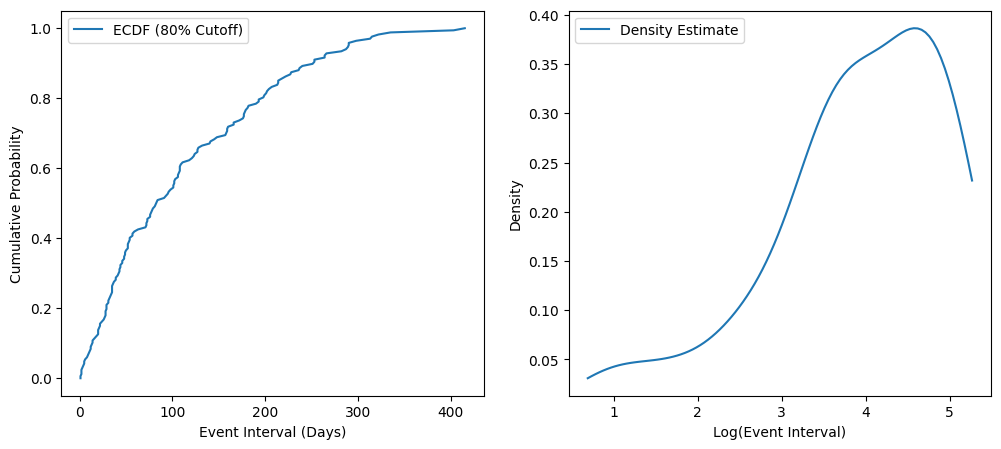

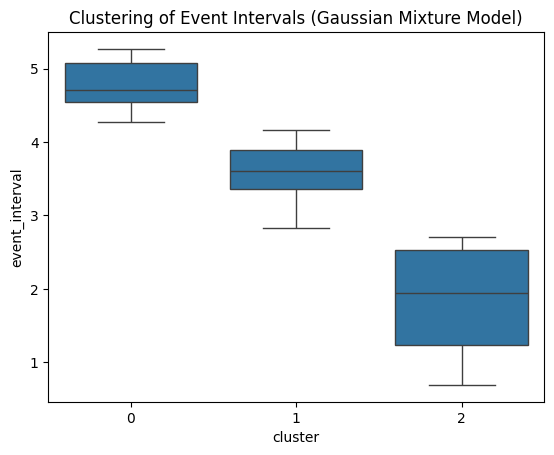

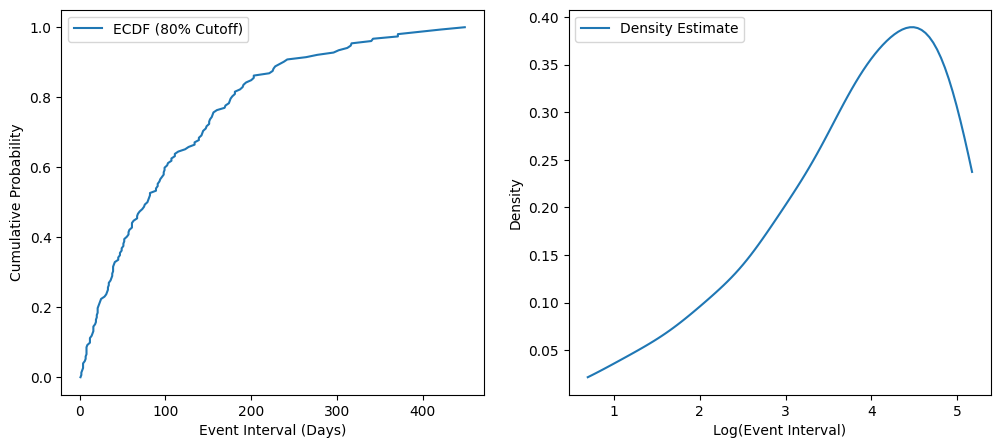

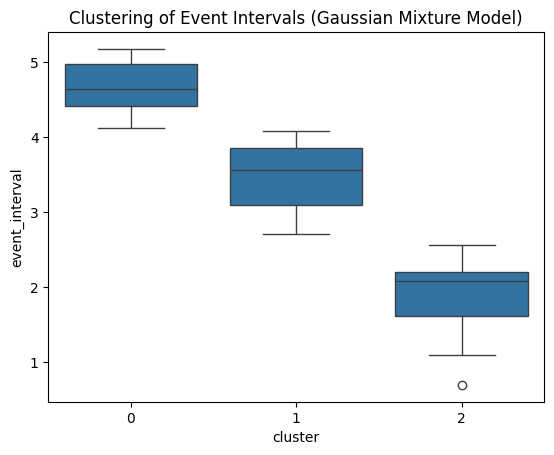

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from scipy.stats import gaussian_kde, boxcox
from scipy.stats import shapiro
from sklearn.mixture import GaussianMixture
from lifelines import KaplanMeierFitter

# Example data: Simulating the dataset
np.random.seed(42)
tidy = pd.DataFrame({
    'pnr': np.random.randint(1, 100, 500),
    'eksd': pd.date_range(start='1/1/2020', periods=500, freq='D'),
    'perday': np.random.randint(1, 5, 500),
    'ATC': np.random.choice(['medA', 'medB'], 500),
    'dur_original': np.random.randint(1, 30, 500)
})

# Convert 'eksd' to datetime
tidy['eksd'] = pd.to_datetime(tidy['eksd'])

def see(arg1):
    # Filtering for given drug
    C09CA01 = tidy[tidy['ATC'] == arg1].copy()

    # Sorting prescriptions per patient
    C09CA01.sort_values(['pnr', 'eksd'], inplace=True)
    C09CA01['prev_eksd'] = C09CA01.groupby('pnr')['eksd'].shift(1)
    
    # Compute event interval (days)
    C09CA01['event_interval'] = (C09CA01['eksd'] - C09CA01['prev_eksd']).dt.days
    C09CA01.dropna(subset=['event_interval'], inplace=True)
    
    # ECDF Distribution (Corrected)
    y = np.linspace(0, 1, len(C09CA01))
    x = np.sort(C09CA01['event_interval'])
    
    # Dynamic Tail Cutoff using Pareto Fit
    cutoff_threshold = np.percentile(x, 80)  # Keep the lower 80%
    C09CA01 = C09CA01[C09CA01['event_interval'] <= cutoff_threshold]
    
    # Log Transformation (Only if skewed)
    if shapiro(C09CA01['event_interval'])[1] < 0.05:  # If not normal
        C09CA01['event_interval'] = np.log1p(C09CA01['event_interval'])
    
    # Density Estimation
    density = gaussian_kde(C09CA01['event_interval'])
    x_d = np.linspace(min(C09CA01['event_interval']), max(C09CA01['event_interval']), 100)
    
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.plot(x, y, label="ECDF (80% Cutoff)")
    plt.xlabel("Event Interval (Days)")
    plt.ylabel("Cumulative Probability")
    plt.legend()
    
    plt.subplot(1, 2, 2)
    plt.plot(x_d, density(x_d), label="Density Estimate")
    plt.xlabel("Log(Event Interval)")
    plt.ylabel("Density")
    plt.legend()
    plt.show()
    
    # Clustering Using Gaussian Mixture Model (GMM)
    gmm = GaussianMixture(n_components=3, random_state=42)
    C09CA01['cluster'] = gmm.fit_predict(C09CA01[['event_interval']])
    
    # Visualizing Clusters
    sns.boxplot(x='cluster', y='event_interval', data=C09CA01)
    plt.title("Clustering of Event Intervals (Gaussian Mixture Model)")
    plt.show()
    
    # Median-based event interval assignment
    median_intervals = C09CA01.groupby('cluster')['event_interval'].median().reset_index()
    
    return C09CA01, median_intervals

# Apply function to drug categories
medA, medA_medians = see("medA")
medB, medB_medians = see("medB")

Optimal K: 6 with silhouette score = 0.558


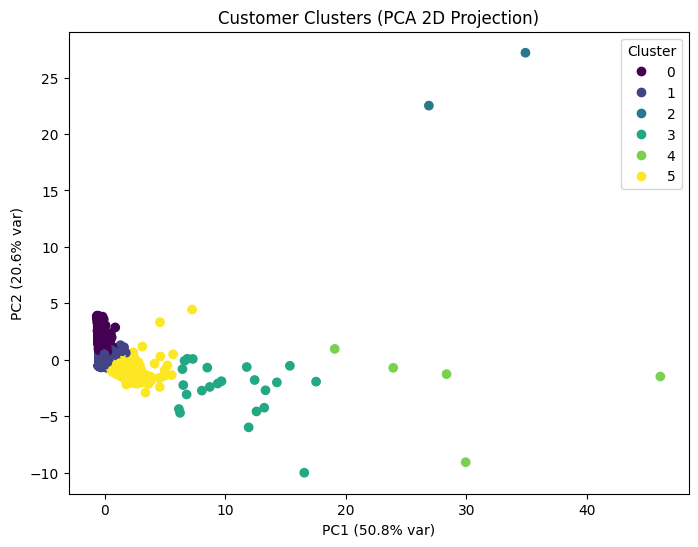

In [ ]:
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_score
from sklearn.decomposition import PCA
import matplotlib.pyplot as plt

# Drop any rows with NaN in features
customer_features = customer_features.dropna()

# Choose the columns you want for clustering
feature_cols = ['total_spend', 'total_invoices', 'avg_spend_per_invoice', 
                'total_items', 'avg_days_diff']

X = customer_features[feature_cols].values

# Standardize the features
scaler = StandardScaler()
X_scaled = scaler.fit_transform(X)

# Find an optimal k using silhouette
K_range = range(2, 10)
best_k = None
best_score = -1
for k in K_range:
    kmeans = KMeans(n_clusters=k, random_state=42)
    labels = kmeans.fit_predict(X_scaled)
    score = silhouette_score(X_scaled, labels)
    if score > best_score:
        best_score = score
        best_k = k

print(f"Optimal K: {best_k} with silhouette score = {best_score:.3f}")

# Cluster with best_k
kmeans = KMeans(n_clusters=best_k, random_state=42)
clusters = kmeans.fit_predict(X_scaled)

# Add cluster labels to our DataFrame
customer_features['cluster'] = clusters

# Perform PCA to get 2D representation
pca = PCA(n_components=2, random_state=42)
X_pca = pca.fit_transform(X_scaled)

# Plot 2D cluster result
plt.figure(figsize=(8, 6))
scatter = plt.scatter(X_pca[:,0], X_pca[:,1], c=clusters, cmap='viridis')
plt.xlabel(f"PC1 ({pca.explained_variance_ratio_[0]*100:.1f}% var)")
plt.ylabel(f"PC2 ({pca.explained_variance_ratio_[1]*100:.1f}% var)")
plt.title("Customer Clusters")
plt.legend(*scatter.legend_elements(), title="Cluster")
plt.show()


## Insights for the Sessa K Means Model 📈
The data used in this case is from Online Retail II of UC Irvine Machine Learning Repository. It has all transactions happening for a UK-based and registered online retail from December 1, 2009 to December 9, 2011. They mainly sell unique all-occasion gifts.

## Substituting K-Means with an Alternative Clustering Algorithm 🔄
K-means has well-known disadvantages—it assumes clusters are spherical, it needs to predetermine the number of clusters, and is very sensitive to outliers. To overcome these issues, you could try using DBSCAN, which can automatically identify the number of clusters and detect noise.

Median durations by DBSCAN cluster:
cluster
0    8.0
Name: days_diff, dtype: float64


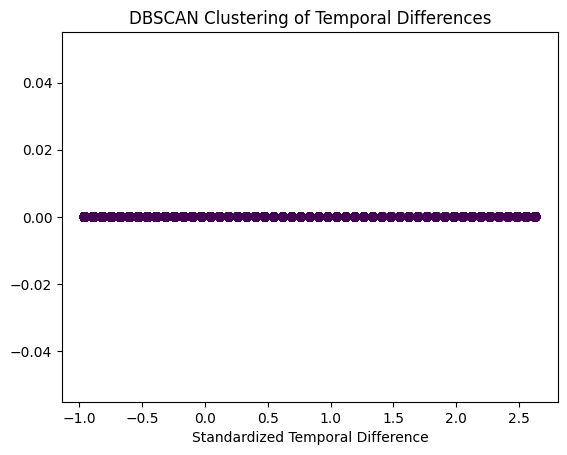

In [3]:
from sklearn.cluster import DBSCAN

# Use DBSCAN on the standardized data
dbscan = DBSCAN(eps=0.5, min_samples=5)
labels_db = dbscan.fit_predict(X)

# Filter out noise points (label = -1)
mask = labels_db != -1
X_db = X[mask]
labels_db = labels_db[mask]

# Create a DataFrame for DBSCAN results
db_df = pd.DataFrame({
    'days_diff': trimmed_diffs[mask],
    'cluster': labels_db
})

# Compute median durations for each DBSCAN cluster
db_cluster_medians = db_df.groupby('cluster')['days_diff'].median()
print("Median durations by DBSCAN cluster:")
print(db_cluster_medians)

# Visualize the clustering results
plt.scatter(X, np.zeros_like(X), c=labels_db, cmap='viridis')
plt.xlabel('Standardized Temporal Difference')
plt.title('DBSCAN Clustering of Temporal Differences')
plt.show()